## Setup and import some libraries

In [1]:
# !pip install wheel==0.38.4
# !pip install setuptools==65
# !pip install gym==0.21
# !pip install torchrl
# pip install stable-baselines3[extra]
# !pip install torchvision
# !pip install gym==0.21
# !pip install --upgrade ipykernel
# !pip install matplotlib
# !pip install gym[atari,accept-rom-license]==0.21.0
# !pip install joblib
# !pip install tqdm

## Подключение библиотек

In [2]:
# hide imports
from IPython.display import clear_output
from PIL import Image
import matplotlib.pyplot as plt
import gym
import torchvision
import numpy as np
import torchrl
import torch
import logging
import tqdm
from torchrl.envs import *
from torchrl.envs.libs.gym import *
from joblib import Parallel, delayed
import warnings
from multiprocessing import Pool
from agent import Agent
from constants import *
warnings.filterwarnings('ignore')

random_seed = 21

torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


Версия gym

In [3]:
gym.version.VERSION

'0.21.0'

# Действие игры происходит в среде gym "Assault"

Давайте поменяем нашу среду для лучшего обучения.

Во-первых сделаем resize картинки до размера 64x64 (W = 64, H = 64).
Во-вторых переведем ее в черно-белое изображение.
В-третьих Добавим frameskip в 4 кадра.

Для этого воспользуемся классом TransformedEnv из torchrl.

In [4]:
#hide changing environment

_env = gym.make("CartPole-v1").env

n_actions = _env.action_space.n # see more info in actions.txt

print("n_actions =", n_actions)

from torchrl.envs import *
from torchrl.envs.libs.gym import *


env = TransformedEnv(
    GymEnv("CartPole-v1", from_pixels=True),
    Compose(
        ToTensorImage(in_keys=["pixels"], out_keys=["pixels_trsf"]),
        Resize(in_keys=["pixels_trsf"], w=W, h=H),
        GrayScale(in_keys=["pixels_trsf"]),
        FrameSkipTransform(1), 
        ExcludeTransform("pixels")
    ),
).to(device)

n_actions = 2


Как мы видим state это TensorDict, состоящий из нескольких параметров, в том числе done, pixels_trsf (Измененное изображение), terminated, truncated.

In [5]:
state = env.reset()

print(state)

TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        pixels_trsf: Tensor(shape=torch.Size([1, 84, 84]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


## Посмотрим, как выглядит изменная среда

torch.Size([1, 84, 84])


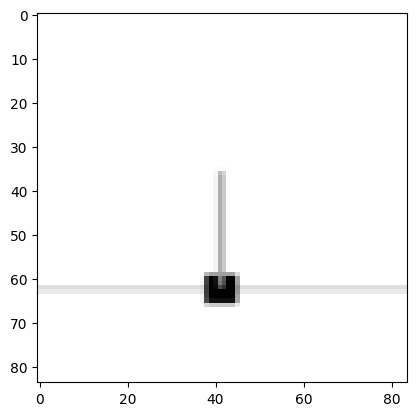

In [6]:
state = env.reset()

print(state['pixels_trsf'].shape)

plt.imshow(state['pixels_trsf'].cpu().permute(1, 2, 0), cmap="gray")

# Обучаем агента

### Для обучения агента я использую:
  * Нейронную сеть, состоящую из сверточных и полносвязных слоев. (Подробнее смотри файл network.py)
  * Реплей с приоритетами (TensorDictReplayBuffer) размера SIZE = 20000.
  * Optimizer - Adam
  * Для пересчета в Q-формуле использую target_network, которую обновляю каждые 30000 фреймов.
  
Для подробностей см. файл agent.py
Также есть возможность загрузки и сохранения агента.

In [7]:
# создаем агента
agent = Agent(num_channels=NUM_CHANNELS, width=W, height=H, n_actions=n_actions)

Добавим для наглядности графики

In [8]:
#hide plot
def plot(agent):
    clear_output(True)
    plt.figure(figsize=(20, 20))
    
    plt.subplot(221)
    plt.title('Rewards per frames')
    plt.xlabel("Frames")
    plt.ylabel("Reward")
    plt.plot(agent.frames, agent.reward_history, color='blue')
    
    plt.subplot(222)
    plt.title('Loss per frames')
    plt.xlabel("Frames")
    plt.ylabel("Loss")
    plt.plot(agent.frames, agent.loss_history, color='orange')
    
    plt.subplot(223)
    plt.title('Rewards per last 100 sessions')
    plt.xlabel("Sessions")
    plt.ylabel("Reward")
    plt.plot(agent.reward_history[-100:], color='blue')
    
    plt.subplot(224)
    plt.title('Loss per last 100 sessions')
    plt.xlabel("Sessions")
    plt.ylabel("Loss")
    plt.plot(agent.loss_history[-100:], color='orange')
    plt.show()

Играем сессию и записываем в агента опыт

In [9]:
# hide session

from tensordict import TensorDict

def play_session(agent, t_max=(int)(1e5), epsilon=0):
    # env = TransformedEnv(
    # GymEnv("CartPole-v1", from_pixels=True),
    # Compose(
    #     ToTensorImage(in_keys=["pixels"], out_keys=["pixels_trsf"]),
    #     Resize(in_keys=["pixels_trsf"], w=W, h=H),
    #     GrayScale(in_keys=["pixels_trsf"]),
    #     FrameSkipTransform(1), 
    #     ExcludeTransform("pixels")
    # )).to(device)

    env = gym.make("CartPole-v1")

    total_reward = 0
    state = env.reset()
    
    frames = 0
    L = 0

    for t in range(t_max):
        action = agent.select_action(state, epsilon=epsilon)

        next_state, reward, done, info = env.step(action)

        _action = torch.tensor(action)
        # _action[action] = 1

        data = TensorDict({
            "state" : torch.as_tensor(state),
            "action" : np.asarray([np.asarray(_action)]),
            "reward": torch.as_tensor(reward),
            "next_state" : torch.as_tensor(next_state),
            "done" : torch.as_tensor(done)
            }, 
            batch_size=[]
        )

        agent.record_experience(data)

        # loss = agent.compute_loss(state['pixels_trsf'], np.asarray([np.asarray(_action)]), [next_state['reward']], next_state['pixels_trsf'], [next_state['done']])

        total_reward += reward

        state = next_state
        
        frames += 1

        if done:
            break
    
    return total_reward, frames

### Выбираем будем ли тренироваться и загружаться

In [10]:
loading = False
training = True
batch_size = 256

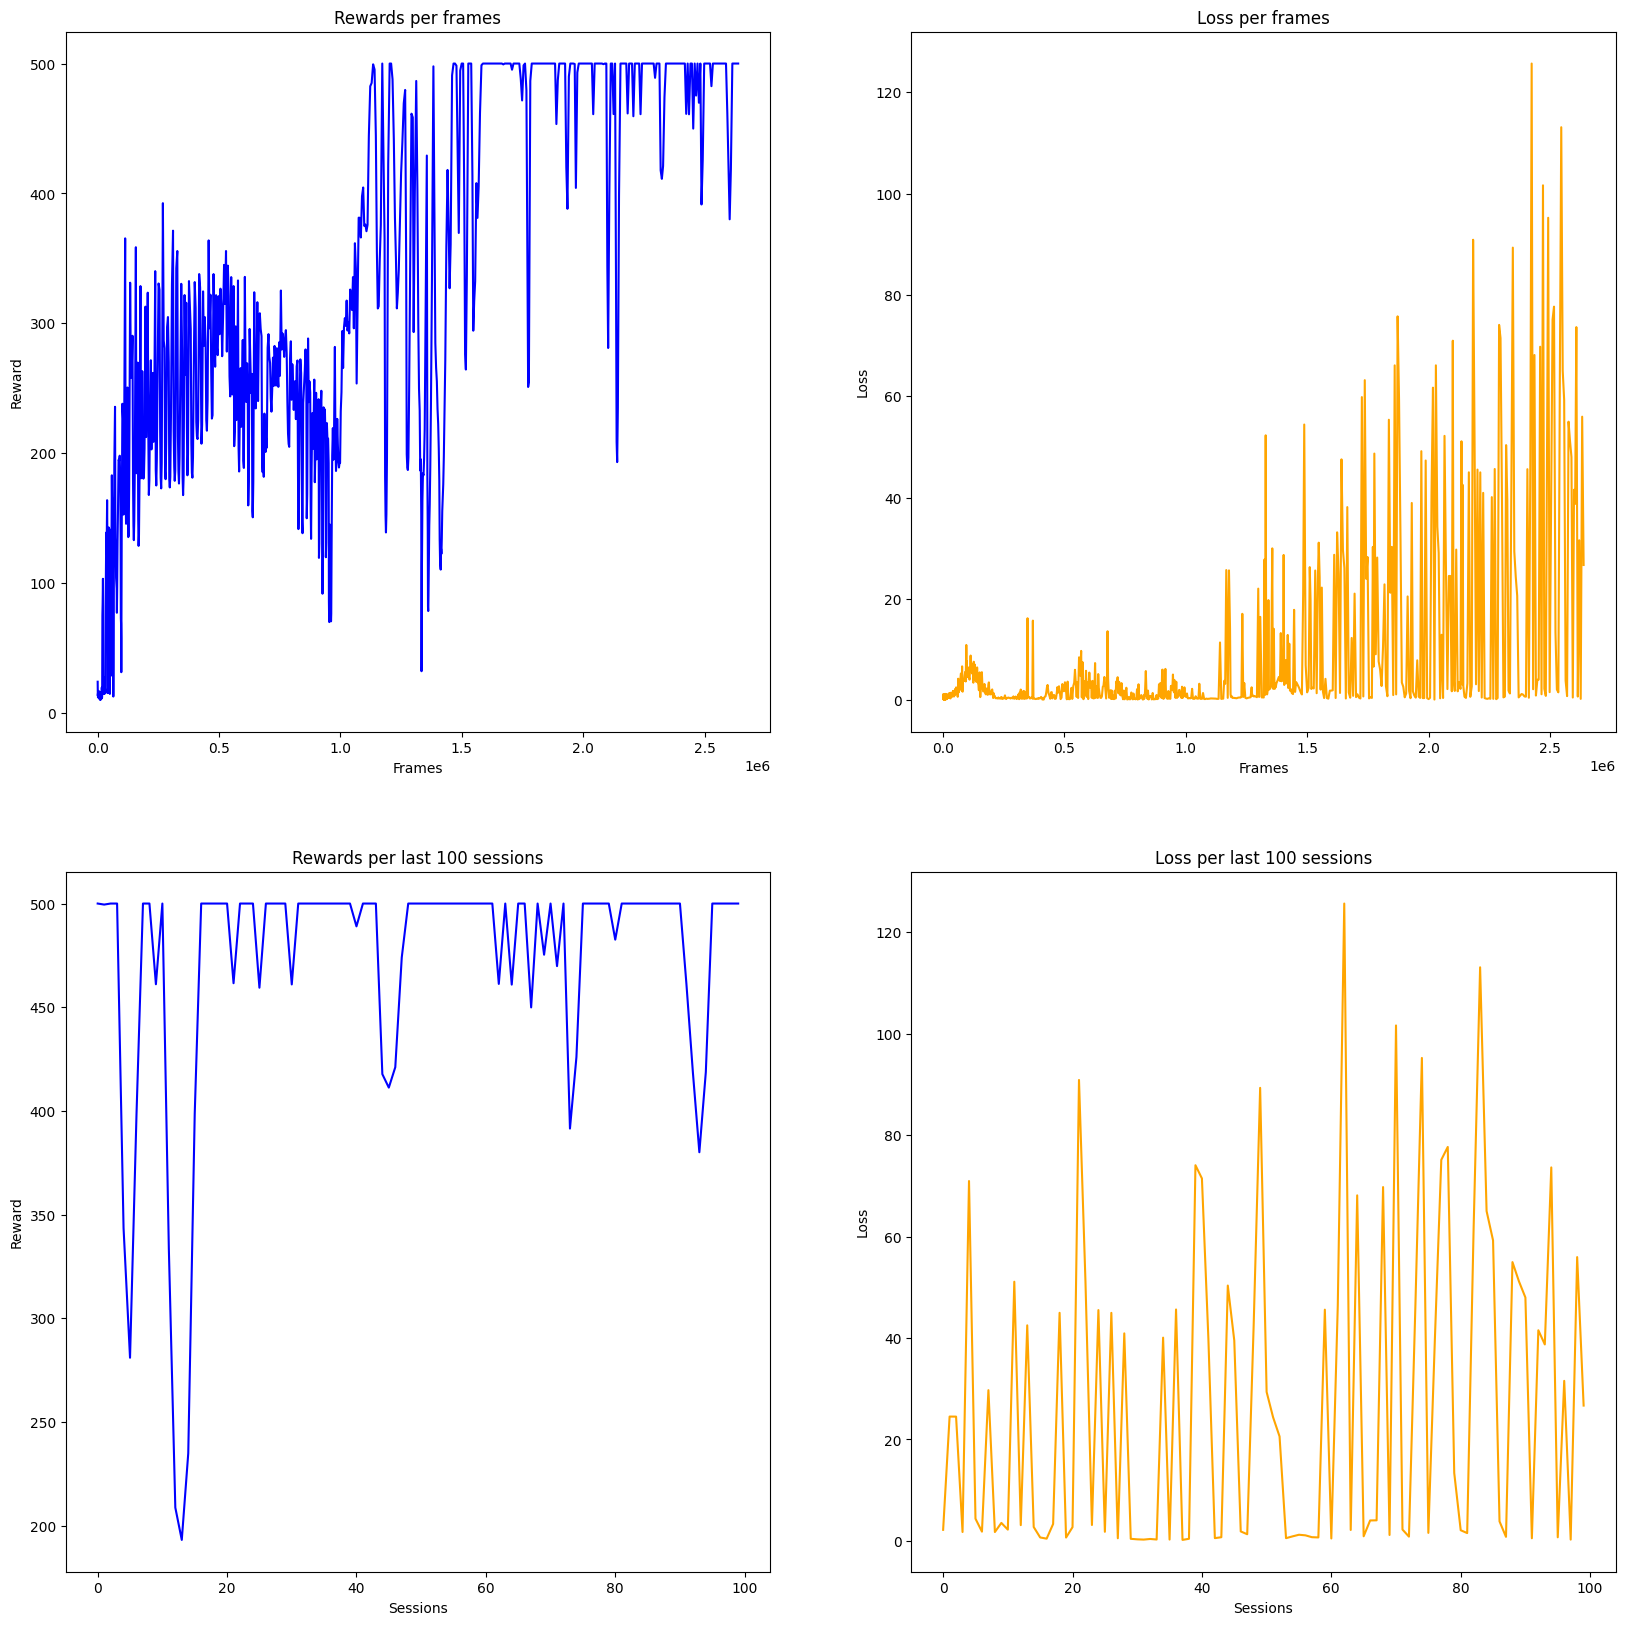

for frame =  2638035 , epsilon =  0.10320700255695461


  0%|          | 0/12 [00:00<?, ?it/s]

tensor([[102.3260,  99.0425]])
tensor([[102.1929, 100.5301]])
tensor([[99.9275, 99.3749]])
tensor([[95.3890, 96.6083]])
tensor([[96.7069, 97.4596]])
tensor([[98.0624, 98.3621]])
tensor([[99.7985, 99.5813]])
tensor([[95.6434, 96.8237]])
tensor([[97.2120, 97.9447]])
tensor([[99.0127, 99.1891]])
tensor([[100.4988, 100.0874]])
tensor([[99.9314, 99.8651]])
tensor([[97.1952, 98.1168]])
tensor([[99.0784, 99.3932]])
tensor([[100.3080,  99.9727]])
tensor([[99.1104, 99.4546]])
tensor([[100.4796, 100.1556]])
tensor([[99.1959, 99.5383]])
tensor([[100.6306, 100.2938]])
tensor([[99.3439, 99.6594]])
tensor([[100.7418, 100.3822]])
tensor([[99.5873, 99.8410]])
tensor([[100.8713, 100.4607]])
tensor([[ 99.9359, 100.0848]])
tensor([[101.0518, 100.5496]])
tensor([[100.3267, 100.3460]])
tensor([[101.2892, 100.6505]])
tensor([[100.7493, 100.6200]])
tensor([[98.8407, 99.4839]])
tensor([[100.5784, 100.5478]])
tensor([[98.5509, 99.3279]])
tensor([[100.3513, 100.4424]])
tensor([[100.7562, 100.7034]])
tensor([[98

  8%|▊         | 1/12 [00:00<00:08,  1.32it/s]

tensor([[101.7645,  99.9723]])
tensor([[101.7712,  99.3344]])
tensor([[102.4888, 100.6834]])
tensor([[102.6643, 101.5072]])
tensor([[102.3853, 101.9794]])
tensor([[101.1328, 101.5903]])
tensor([[102.1498, 101.9434]])
tensor([[100.7904, 101.4804]])
tensor([[101.7923, 101.8628]])
tensor([[102.3959, 100.6036]])
tensor([[102.5941, 101.5132]])
tensor([[102.2467, 101.9672]])
tensor([[100.9211, 101.5448]])
tensor([[102.3684, 101.5710]])
tensor([[101.8336, 101.8725]])
tensor([[102.3421, 101.5779]])
tensor([[101.7849, 101.8606]])
tensor([[102.3087, 101.5871]])
tensor([[101.7233, 101.8457]])
tensor([[102.2670, 101.5987]])
tensor([[101.6471, 101.8273]])
tensor([[102.2161, 101.6132]])
tensor([[101.5542, 101.8050]])
tensor([[102.1545, 101.6310]])
tensor([[101.4419, 101.7782]])
tensor([[102.0805, 101.6525]])
tensor([[101.2939, 101.7302]])
tensor([[101.9922, 101.6783]])
tensor([[101.0574, 101.6056]])
tensor([[101.8874, 101.7091]])
tensor([[100.7748, 101.4557]])
tensor([[101.7634, 101.7457]])
tensor([

 17%|█▋        | 2/12 [00:01<00:06,  1.64it/s]

tensor([[102.3497, 101.7105]])
tensor([[101.6218, 101.8187]])
tensor([[102.3200, 101.7150]])
tensor([[101.5705, 101.8124]])
tensor([[102.2710, 101.7257]])
tensor([[101.4726, 101.7843]])
tensor([[102.2015, 101.7430]])
tensor([[101.3255, 101.7339]])
tensor([[102.1094, 101.7675]])
tensor([[101.1164, 101.6494]])
tensor([[101.9924, 101.7999]])
tensor([[100.8027, 101.4851]])
tensor([[101.8221, 101.8180]])
tensor([[ 98.4073, 100.2241]])
tensor([[ 99.2926, 100.6928]])
tensor([[100.4600, 101.3029]])
tensor([[101.3378, 101.4420]])
tensor([[101.4574, 100.5291]])
tensor([[101.6854, 100.4013]])
tensor([[101.9265, 101.3472]])
tensor([[101.5748, 101.7530]])
tensor([[102.0433, 101.3146]])
tensor([[101.7872, 101.8025]])
tensor([[102.1871, 101.2737]])
tensor([[102.0020, 101.8045]])
tensor([[102.2411, 101.2260]])
tensor([[102.0861, 101.7870]])
tensor([[102.0047, 101.8071]])
tensor([[100.8323, 101.4938]])
tensor([[101.8703, 101.8141]])
tensor([[100.5447, 101.3458]])
tensor([[101.6590, 101.7786]])
tensor([

 25%|██▌       | 3/12 [00:01<00:04,  1.96it/s]

tensor([[100.8235, 101.5009]])
tensor([[101.8210, 101.7609]])
tensor([[100.5939, 101.3816]])
tensor([[101.6882, 101.7695]])
tensor([[102.0035, 101.1627]])
tensor([[101.8627, 101.7515]])
tensor([[100.7030, 101.4362]])
tensor([[101.7620, 101.7675]])
tensor([[102.0600, 101.1316]])
tensor([[101.9396, 101.7308]])
tensor([[100.9082, 101.5427]])
tensor([[101.8699, 101.7493]])
tensor([[101.7737, 101.7678]])
tensor([[100.4878, 101.3259]])
tensor([[101.6181, 101.7576]])
tensor([[101.9764, 101.1995]])
tensor([[101.8130, 101.7652]])
tensor([[100.5766, 101.3705]])
tensor([[101.6870, 101.7662]])
tensor([[102.0244, 101.1747]])
tensor([[101.8795, 101.7495]])
tensor([[100.7500, 101.4608]])
tensor([[101.7960, 101.7655]])
tensor([[100.5448, 101.3556]])
tensor([[101.6660, 101.7663]])
tensor([[101.8606, 101.7551]])
tensor([[100.7022, 101.4373]])
tensor([[100.4876, 101.3270]])
tensor([[101.6248, 101.7595]])
tensor([[101.9903, 101.2025]])
tensor([[101.8290, 101.7638]])
tensor([[100.6221, 101.3967]])
tensor([

 33%|███▎      | 4/12 [00:02<00:03,  2.17it/s]

tensor([[101.5889, 101.4115]])
tensor([[100.9216, 101.5210]])
tensor([[101.6373, 101.4009]])
tensor([[101.0414, 101.5772]])
tensor([[101.7058, 101.3838]])
tensor([[101.2045, 101.6504]])
tensor([[101.8488, 100.2448]])
tensor([[102.1903, 101.2508]])
tensor([[102.0308, 101.7835]])
tensor([[100.9421, 101.5262]])
tensor([[101.9767, 101.7905]])
[500. 500. 500.] 500.0
tensor([[101.8914,  98.1133]])
tensor([[102.6513,  99.6864]])
tensor([[102.1918, 100.2584]])
tensor([[99.8200, 99.0974]])
tensor([[94.4821, 95.7252]])
tensor([[95.5479, 96.4484]])
tensor([[97.2784, 97.7080]])
tensor([[98.7195, 98.7139]])
tensor([[93.6759, 95.3131]])
tensor([[89.3249, 92.3667]])
tensor([[90.6452, 93.4296]])
tensor([[92.2723, 94.6915]])
tensor([[94.1079, 96.0916]])
tensor([[95.8473, 97.3620]])
tensor([[97.1274, 98.1387]])
tensor([[98.3032, 98.5270]])
tensor([[98.2923, 97.3429]])
tensor([[99.5161, 99.0018]])
tensor([[100.6170, 100.0938]])
tensor([[100.2229, 100.1878]])
tensor([[98.2863, 99.0208]])
tensor([[100.1728

 42%|████▏     | 5/12 [00:02<00:03,  2.29it/s]

tensor([[101.7277, 101.7961]])
tensor([[102.1676, 101.3700]])
tensor([[101.8435, 101.8227]])
tensor([[100.3576, 101.2009]])
tensor([[101.5372, 101.7529]])
tensor([[102.0340, 101.4069]])
tensor([[101.6013, 101.7671]])
tensor([[102.0819, 101.3945]])
tensor([[101.6885, 101.7870]])
tensor([[102.1437, 101.3777]])
tensor([[101.8010, 101.8129]])
tensor([[102.2212, 101.3560]])
tensor([[101.9416, 101.8455]])
tensor([[100.5225, 101.2888]])
tensor([[101.6629, 101.7823]])
tensor([[101.7579, 101.8038]])
tensor([[102.1874, 101.3644]])
tensor([[101.8800, 101.8319]])
tensor([[ 98.3415, 100.1390]])
tensor([[ 99.2615, 100.6340]])
tensor([[100.4536, 101.2794]])
tensor([[101.4297, 101.5370]])
tensor([[101.6236, 100.7455]])
tensor([[101.6584, 101.5195]])
tensor([[100.7748, 101.4372]])
tensor([[101.6437, 101.5258]])
tensor([[100.7363, 101.4165]])
tensor([[101.8155, 100.6724]])
tensor([[101.9039, 101.4575]])
tensor([[101.3735, 101.7119]])
tensor([[101.9663, 101.4395]])
tensor([[101.4873, 101.7392]])
tensor([

 50%|█████     | 6/12 [00:02<00:02,  2.31it/s]

tensor([[102.0604, 101.2970]])
tensor([[101.7421, 101.8062]])
tensor([[102.0869, 101.3343]])
tensor([[101.7413, 101.8032]])
tensor([[102.1189, 101.3556]])
tensor([[101.7670, 101.8069]])
tensor([[102.1503, 101.3531]])
tensor([[101.8200, 101.8174]])
tensor([[100.2866, 101.1598]])
tensor([[101.4287, 101.7063]])
tensor([[101.9452, 101.4141]])
tensor([[101.4371, 101.7157]])
tensor([[101.9548, 101.4142]])
tensor([[101.4672, 101.7327]])
tensor([[101.9755, 101.4106]])
tensor([[101.5053, 101.7406]])
tensor([[102.0078, 101.4032]])
tensor([[101.5646, 101.7537]])
[500. 500. 500. 500. 500.] 500.0
tensor([[101.1415,  97.1807]])
tensor([[101.9501,  98.6601]])
tensor([[102.2850,  99.8339]])
tensor([[101.0038,  99.5845]])
tensor([[97.8786, 97.9005]])
tensor([[99.3005, 98.8439]])
tensor([[93.1407, 94.6853]])
tensor([[94.7172, 95.8407]])
tensor([[96.4531, 97.1171]])
tensor([[98.0746, 98.2881]])
tensor([[99.6971, 99.3872]])
tensor([[96.1948, 97.1122]])
tensor([[97.9689, 98.3665]])
tensor([[99.5129, 99.372

 58%|█████▊    | 7/12 [00:03<00:02,  2.28it/s]

tensor([[102.0459, 101.1314]])
tensor([[101.9225, 101.7223]])
tensor([[100.8929, 101.5317]])
tensor([[101.8596, 101.7388]])
tensor([[100.7275, 101.4473]])
tensor([[101.7772, 101.7596]])
tensor([[100.5135, 101.3369]])
tensor([[101.6430, 101.7600]])
tensor([[101.9837, 101.1754]])
tensor([[101.8336, 101.7476]])
tensor([[100.6592, 101.4119]])
tensor([[101.7375, 101.7585]])
tensor([[102.0493, 101.1314]])
tensor([[101.9275, 101.7218]])
tensor([[ 99.0497, 100.5802]])
tensor([[100.0964, 101.1238]])
tensor([[101.2940, 101.6545]])
tensor([[101.7917, 101.2707]])
tensor([[101.4965, 101.7263]])
tensor([[101.9209, 101.2369]])
tensor([[101.7118, 101.7546]])
tensor([[102.0592, 101.1577]])
tensor([[101.9255, 101.7259]])
tensor([[100.9095, 101.5435]])
tensor([[101.8767, 101.7377]])
tensor([[100.7828, 101.4804]])
tensor([[101.8110, 101.7550]])
tensor([[100.6100, 101.3923]])
tensor([[101.7033, 101.7586]])
tensor([[102.0282, 101.1456]])
tensor([[101.9005, 101.7307]])
tensor([[100.8498, 101.5178]])
tensor([

 67%|██████▋   | 8/12 [00:03<00:01,  2.31it/s]

tensor([[101.6384, 101.8337]])
tensor([[102.2938, 101.6721]])
tensor([[101.6155, 101.8298]])
tensor([[102.2681, 101.6765]])
tensor([[101.5675, 101.8196]])
tensor([[102.2278, 101.6857]])
tensor([[101.4930, 101.8030]])
tensor([[102.1715, 101.7000]])
tensor([[ 99.5322, 100.8423]])
tensor([[100.5560, 101.3635]])
tensor([[101.6281, 101.7675]])
tensor([[101.9590, 101.2174]])
tensor([[101.7679, 101.7952]])
tensor([[101.9155,  99.8105]])
tensor([[102.5908, 100.4513]])
tensor([[102.9419, 101.4689]])
tensor([[102.7572, 102.0184]])
tensor([[101.7048, 101.8361]])
tensor([[102.5723, 102.0265]])
tensor([[101.3803, 101.7325]])
tensor([[102.2535, 101.9804]])
tensor([[100.9013, 101.5510]])
tensor([[101.7960, 101.8754]])
tensor([[102.4034, 100.7219]])
tensor([[102.5207, 101.5880]])
tensor([[102.0116, 101.9219]])
tensor([[100.4921, 101.3241]])
tensor([[101.4905, 101.8018]])
tensor([[102.2502, 100.8780]])
tensor([[102.2681, 101.6600]])
tensor([[101.5512, 101.8120]])
tensor([[102.1778, 101.6857]])
tensor([

 67%|██████▋   | 8/12 [00:04<00:02,  1.96it/s]

tensor([[100.8192, 101.5063]])
tensor([[102.0997, 101.0722]])
tensor([[102.0193, 101.6961]])
tensor([[101.1531, 101.6644]])
tensor([[101.9848, 101.7040]])
tensor([[101.9365, 101.7162]])
tensor([[100.9623, 101.5859]])
tensor([[101.8733, 101.7332]])
tensor([[100.7943, 101.4991]])


KeyboardInterrupt: 

In [11]:
if training:
    if loading:
        agent.load()

    agent.save()

    print("preparing (add random states to replay buffer)")
    if not loading:
        for i in tqdm.tqdm(range(2000)):
            play_session(agent, epsilon=1)
    else:
        for i in tqdm.tqdm(range(20)):
            play_session(agent, epsilon=agent.epsilon)
    
    epoch = 0
    while True:
        rewards = np.asarray([])
        count_frames = 0
        for _ in tqdm.tqdm(range(12)):
                rewards_for_session, cnt = play_session(agent, t_max=(int)(agent.t_max), epsilon=agent.epsilon)
                rewards_for_session = np.asarray(torch.as_tensor(rewards_for_session).cpu())
                print(rewards, rewards_for_session)
                rewards = np.concatenate([rewards, [rewards_for_session]])
                count_frames += cnt
        
        agent.epsilon *= 0.99

        # loss = agent.train(batch_size)
        
        Loss = agent.train(400)
        agent.loss_history.append(Loss)
        agent.reward_history.append(np.mean(rewards))
        last_frames = 0
        if len(agent.frames) != 0:
            last_frames = agent.frames[-1]
        agent.frames.append(last_frames + count_frames)
        clear_output(True)
        
        plot(agent)
        print("for frame = ", last_frames + count_frames, ", epsilon = ", agent.epsilon)

        if agent.epsilon < 0.1:
            agent.epsilon = 0.12
        
        agent.t_max *= 1.01
        epoch += 1
        agent.t_max = min(agent.t_max, (int)(4e4))

        if epoch % 10 == 1:
            agent.save()
            print('saved successfully')     

In [ ]:
if not training:
    pass # lets see result!